Download and process workbench studies

In [156]:
import requests
import pandas as pd
import os.path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from networkx.algorithms import bipartite
import libchebipy

In [213]:
base_url = 'https://www.metabolomicsworkbench.org/rest/study/analysis_id/'

In [458]:

studies = ['ST002016', 'ST001736', 'ST002301', 'ST001933', 'ST000899', 'ST000284', 'ST002428', 'ST000974', 'ST002100']
studies_assays = dict.fromkeys(studies)


In [432]:
studies_assays


{'ST002016': ['AN003284', 'AN003285'],
 'ST001736': ['AN002826', 'AN002827'],
 'ST002301': ['AN003757'],
 'ST001933': ['AN003143'],
 'ST000899': ['AN001462', 'AN001463', 'AN001464', 'AN001465'],
 'ST000284': ['AN000452'],
 'ST002428': ['AN003951', 'AN003952']}

In [459]:

# Get assays for each study
for s in studies:
    
    base_url = 'https://www.metabolomicsworkbench.org/rest/study/study_id/repl/analysis'
    resp = requests.get(base_url.replace('repl', s)).json()
    print(resp)
    if list(resp.keys())[0] != '1':
        resp_series = pd.Series(resp)
        print(resp_series['analysis_id'])
        studies_assays[s] = [resp_series['analysis_id']]
    else:
        resp_df = pd.DataFrame.from_dict(resp).T
        print(resp_df['analysis_id'].tolist())
        studies_assays[s] = resp_df['analysis_id'].tolist()



{'1': {'study_id': 'ST002016', 'analysis_id': 'AN003284', 'analysis_summary': 'Reversed phase POSITIVE ION MODE', 'analysis_type': 'MS', 'chromatography system': 'Thermo Vanquish', 'column_name': 'Thermo Accucore C18 (100 x 2.1mm,2.6um)', 'chromatography_type': 'Reversed phase', 'ms_instrument_name': 'Thermo Orbitrap ID-X tribrid', 'ms_instrument_type': 'Orbitrap', 'ms_type': 'ESI', 'ion_mode': 'POSITIVE', 'nmr_instrument_type': '', 'nmr_experiment_type': '', 'spectrometer_frequency': '', 'nmr_solvent': '', 'units': 'intensity'}, '2': {'study_id': 'ST002016', 'analysis_id': 'AN003285', 'analysis_summary': 'Reversed phase NEGATIVE ION MODE', 'analysis_type': 'MS', 'chromatography system': 'Thermo Vanquish', 'column_name': 'Thermo Accucore C18 (100 x 2.1mm,2.6um)', 'chromatography_type': 'Reversed phase', 'ms_instrument_name': 'Thermo Orbitrap ID-X tribrid', 'ms_instrument_type': 'Orbitrap', 'ms_type': 'ESI', 'ion_mode': 'NEGATIVE', 'nmr_instrument_type': '', 'nmr_experiment_type': '', '

{'1': {'study_id': 'ST001736', 'analysis_id': 'AN002826', 'analysis_summary': 'Reversed phase POSITIVE ION MODE', 'analysis_type': 'MS', 'chromatography system': 'Thermo Vanquish', 'column_name': 'Phenomenex Kinetex C18 (150 x 2.1mm,1.7um)', 'chromatography_type': 'Reversed phase', 'ms_instrument_name': 'Thermo Q Exactive Orbitrap', 'ms_instrument_type': 'Orbitrap', 'ms_type': 'ESI', 'ion_mode': 'POSITIVE', 'nmr_instrument_type': '', 'nmr_experiment_type': '', 'spectrometer_frequency': '', 'nmr_solvent': '', 'units': 'peak area'}, '2': {'study_id': 'ST001736', 'analysis_id': 'AN002827', 'analysis_summary': 'Reversed phase NEGATIVE ION MODE', 'analysis_type': 'MS', 'chromatography system': 'Thermo Vanquish', 'column_name': 'Phenomenex Kinetex C18 (150 x 2.1mm,1.7um)', 'chromatography_type': 'Reversed phase', 'ms_instrument_name': 'Thermo Q Exactive Orbitrap', 'ms_instrument_type': 'Orbitrap', 'ms_type': 'ESI', 'ion_mode': 'NEGATIVE', 'nmr_instrument_type': '', 'nmr_experiment_type': '',

In [460]:
# download all assays per study
for study in studies:
    print(study)
    base_url = 'https://www.metabolomicsworkbench.org/rest/study/analysis_id/'
    #check if directory exists
    if not os.path.isdir('Studies/'+study):
        os.mkdir('Studies/'+study)

        for assay in studies_assays[study]:
            url = base_url + assay + '/datatable/file'
            print(url)
            pd.read_csv(url, sep='\t').to_csv('Studies/'+study+'/'+f'{assay}.csv', index=False)



ST002016
ST001736
ST002301
ST001933
ST000899
ST000284
ST002428
ST000974
ST002100
https://www.metabolomicsworkbench.org/rest/study/analysis_id/AN003432/datatable/file
https://www.metabolomicsworkbench.org/rest/study/analysis_id/AN003433/datatable/file


In [220]:
# manually edit metadata
an002826 = pd.read_csv('Studies/ST001736/AN002826.csv')
an002826['Class'] = an002826['Class'].str.split(' | ').str[0]
an002826.to_csv('Studies/ST001736/AN002826.csv', index=False)

an002827 = pd.read_csv('Studies/ST001736/AN002827.csv')
an002827['Class'] = an002827['Class'].str.split(' | ').str[0]
an002827.to_csv('Studies/ST001736/AN002827.csv', index=False)

In [390]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from scipy import stats
from statsmodels.stats.multitest import multipletests
import networkx as nx
import glob
import sspa

class WorkbenchDataset:
    '''AN003284.csv
    Class to process Metabolomics Workbench datasets
    '''

    def __init__(self, study_id, md_filter, outliers=None, remove_suffix=None, pathway_level=False,):
        self.study_id = study_id
        self.md_filter = md_filter
        self.raw_data = None
        self.outliers = outliers
        self.pathway_level = pathway_level
        self.pathway_coverage = None
        self.pathway_data = None
        self.DA_metabolites = None
        self.node_name = study_id
        self.remove_suffix = remove_suffix

        self.read_data()
        # self.get_pathway_data()
        self.da_testing()

    def read_data(self):
        # check if there are multiple files in folder
        files = glob.glob('Studies/'+self.study_id+'/*.csv')
        if len(files) > 1:
            # read in all files and concatenate
            dfs = []
            dfs_proc = []
            for f in files:
                df = pd.read_csv(f)
                dfs.append(df)
                df.index = df['Samples']
                self.raw_data = df

                df_proc = self.preprocess_data()
                dfs_proc.append(df_proc)

            self.raw_data = pd.concat(dfs, axis=1)
            self.processed_data = pd.concat(dfs_proc, axis=1)
            self.processed_data = self.processed_data.loc[:, ~self.processed_data.columns.duplicated()]
            # move group column to end
            cols = [col for col in self.processed_data.columns if col != 'Group'] + ['Group']
            self.processed_data = self.processed_data[cols]

        else:
            data = pd.read_csv(files[0])
            data.index = data['Samples']
            self.raw_data = data

            data_proc = self.preprocess_data()
            self.processed_data = data_proc


        metadata = self.raw_data['Class']
        self.metadata = metadata

        return self.processed_data, self.metadata
    
    def preprocess_data(self):
        '''Preprocess data'''
        data_filt = self.raw_data.copy()
        # drop duplicate columns

        # filter on metadata
        md_dict = dict(zip(self.raw_data['Samples'], self.raw_data['Class']))
        data_filt = data_filt[data_filt['Class'].isin(self.md_filter.values())]
        data_filt = data_filt.drop(columns=['Class', 'Samples'])

        # convert to refmet id
        mets_url = 'https://www.metabolomicsworkbench.org/rest/study/study_id/repl/metabolites'
        mets = requests.get(mets_url.replace('repl', self.study_id)).text
        mets_df = pd.read_json(mets).T
        mets_dict = dict(zip(mets_df['metabolite_name'], mets_df['refmet_name']))
        data_filt.columns = data_filt.columns.map(mets_dict)

        # drop na column names
        data_filt = data_filt.loc[:, data_filt.columns.notna()]

        try:
            data_filt = data_filt.drop(columns=[''])
        except KeyError:
            pass

        # drop outliers
        if self.outliers:
            data_filt = data_filt.drop(self.outliers)

        # Missingness checks 
        # replace empty strings with NaN
        data_filt = data_filt.replace(['', ' ', 0], np.nan)
        # Delete colums and rows where all values are missing
        data_filt = data_filt.dropna(axis=0, how='all')
        data_filt = data_filt.dropna(axis=1, how='all')

        # Delete rows and columns where all values are 0 
        data_filt = data_filt.loc[:, (data_filt != 0).any(axis=0)]
        data_filt = data_filt.loc[(data_filt != 0).any(axis=1), :]

        data_filt = data_filt.dropna(axis=1, thresh=0.5*data_filt.shape[0])
        missing_pct = data_filt.isnull().sum().sum() / (data_filt.shape[0] * data_filt.shape[1]) * 100
        print(f"Missingness: {missing_pct:.2f}%")

        # impute missing values
        imputer = KNNImputer(n_neighbors=2, weights="uniform").set_output(transform="pandas")
        data_imputed = imputer.fit_transform(data_filt)

        # log transformation
        data_imputed = np.log(data_imputed + 1)

        # standardize
        scaler = StandardScaler().set_output(transform="pandas")
        data_scaled = scaler.fit_transform(data_imputed)

        data_scaled['Group'] = data_scaled.index.map(md_dict)
        # self.processed_data = data_scaled

        return data_scaled


    def get_pathway_data(self):
        reactome_paths = sspa.process_gmt(infile='Reactome_Homo_sapiens_pathways_ChEBI_R88.gmt')
        reactome_dict = sspa.utils.pathwaydf_to_dict(reactome_paths)
        # remove CHEBI: from column names
        data = self.processed_data
        data.columns = data.columns.str.removeprefix("CHEBI:")

        # store pathway coverage stats
        cvrg_dict = {k: len(set(data.columns).intersection(set(v))) for k, v in reactome_dict.items()}
        self.pathway_coverage = cvrg_dict

        scores = sspa.sspa_KPCA(reactome_paths).fit_transform(data.iloc[:, :-1])
        scores['Group'] = self.processed_data['Group']
        self.pathway_data = scores
 
    def plot_qc(self):
        # PCA biplot
        pca = PCA(n_components=2).set_output(transform="pandas")
        pca_result = pca.fit_transform(self.processed_data.iloc[:, :-1])
        self.pca = pca_result

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        sns.scatterplot(
            x=pca_result.iloc[:, 0], y=pca_result.iloc[:, 1],
            hue="Group",
            data=self.processed_data,
            alpha=0.7,
            ax=ax1
        )

        # normality every nth feature
        normaliser = 10 * self.processed_data.shape[1]
        data_long = self.processed_data.melt(id_vars='Group')
        sns.boxplot(data=data_long.iloc[0:normaliser, :], ax=ax2, hue='Group', x='variable', y='value')
        ax2.axhline(0, color='red', linestyle='--')
        plt.show()


    def da_testing(self):

        if self.pathway_level == True:
            dat = self.pathway_data
        else:
            dat = self.processed_data

        # t-test for two groups
        case = self.md_filter['Case']
        control = self.md_filter['Control']
        
        stat, pvals = stats.ttest_ind(dat[dat['Group'] == case].iloc[:, :-1],
                        dat[dat['Group'] == control].iloc[:, :-1],
                        alternative='two-sided', nan_policy='raise')
        pval_df = pd.DataFrame(pvals, index=dat.columns[:-1], columns=['P-value'])
        pval_df['Stat'] = stat
        pval_df['Direction'] = ['Up' if x > 0 else 'Down' for x in stat]
        self.pval_df = pval_df

        # fdr correction 
        pval_df['FDR_P-value'] = multipletests(pvals, method='fdr_bh')[1]

        # return significant metabolites
        self.DA_metabolites = pval_df[pval_df['FDR_P-value'] < 0.05].index.tolist()
        print(f"Number of differentially abundant metabolites: {len(self.DA_metabolites)}") 

        # generate tuples for nx links
        self.connection = [(self.node_name, met) for met in self.DA_metabolites]
        self.full_connection = [(self.node_name, met) for met in self.processed_data.columns[:-1]]



## COVID

In [353]:
# manually edit 
an003284 = pd.read_csv('Studies\ST002016\AN003284.csv')

<>:2: SyntaxWarning: invalid escape sequence '\S'
<>:2: SyntaxWarning: invalid escape sequence '\S'
C:\Users\cw2019\AppData\Local\Temp\ipykernel_66232\3726228951.py:2: SyntaxWarning: invalid escape sequence '\S'
  an003284 = pd.read_csv('Studies\ST002016\AN003284.csv')


In [358]:
an003284[an003284.Samples.str.contains('NEG')]

,Samples,Class,10-Hydroxycarbazepine,11-Aminoundecanoic acid,11-Nitro-1-undecene,1-(1Z-hexadecenyl)-sn-glycero-3-phosphocholine,12-Aminododecanoic acid,12-Hydroxydihydrochelirubine,1_3_5-Heptatriene,1_3-Dicyclohexylurea,...,Venlafaxine,Veronal,Vestitol,Xanthine,Xanthohumol,Zalcitabine,Zearalenone,(Z)-Thiamethoxam,α-Aspartylphenylalanine,γ-Linolenic acid ethyl ester
0,Blank_01_NEG,group:-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Blank_02_NEG,group:-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Pooled_QC_ID_01_NEG,group:-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Pooled_QC_ID_02_NEG,group:-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Pooled_QC_ID_03_NEG,group:-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312,QC5_NEG,group:QC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
314,QC6_NEG,group:QC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
316,QC7_NEG,group:QC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
318,QC8_NEG,group:QC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [360]:
an003284 = an003284[~an003284.Samples.str.contains('NEG')]

In [362]:
an003284.Samples = an003284.Samples.str[:-4]

C:\Users\cw2019\AppData\Local\Temp\ipykernel_66232\2877762982.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  an003284.Samples = an003284.Samples.str[:-4]


In [364]:
an003284.to_csv('Studies\ST002016\AN003284.csv', index=False)

<>:1: SyntaxWarning: invalid escape sequence '\S'
<>:1: SyntaxWarning: invalid escape sequence '\S'
C:\Users\cw2019\AppData\Local\Temp\ipykernel_66232\4122490758.py:1: SyntaxWarning: invalid escape sequence '\S'
  an003284.to_csv('Studies\ST002016\AN003284.csv', index=False)


In [365]:
# manually edit 
an003285 = pd.read_csv('Studies\ST002016\AN003285.csv')
an003285 = an003285[~an003285.Samples.str.contains('POS')]
an003285.Samples = an003285.Samples.str[:-4]
an003285.to_csv('Studies\ST002016\AN003285.csv', index=False)

<>:2: SyntaxWarning: invalid escape sequence '\S'
<>:5: SyntaxWarning: invalid escape sequence '\S'
<>:2: SyntaxWarning: invalid escape sequence '\S'
<>:5: SyntaxWarning: invalid escape sequence '\S'
C:\Users\cw2019\AppData\Local\Temp\ipykernel_66232\731885699.py:2: SyntaxWarning: invalid escape sequence '\S'
  an003285 = pd.read_csv('Studies\ST002016\AN003285.csv')
C:\Users\cw2019\AppData\Local\Temp\ipykernel_66232\731885699.py:5: SyntaxWarning: invalid escape sequence '\S'
  an003285.to_csv('Studies\ST002016\AN003285.csv', index=False)


In [366]:
an003285

,Samples,Class,1_3-Dithiane,1_4-Diguanidinobutane,2-Amino-6-hydroxyaminopurine,2-Hydroxyethanesulfonate,2-Hydroxyfluorene,2-Methacryloyloxyethyl phenyl phosphate,2-Methyl-3-thioacetoxy-4_5-dihydrofuran,3_7_3^_4^-Tetramethylquercetin,...,SAT,Ser-Ser,Succinic acid,tebuthiuron,Thiamin,Thiolactomycin,Tilnoprofen arbamel,Uridine,Xanthohumol,Xanthone
0,Blank_01,group:-,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,Blank_02,group:-,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,Pooled_QC_ID_01,group:-,2545352.88,27909.57,482153.24,95642.79,1483686.89,14731.59,275516.90,130585.66,...,44849.42,89477.35,1594118.11,51278.57,23812.57,38639958.92,260952.49,24178.74,20706.02,7819181.57
6,Pooled_QC_ID_02,group:-,2932817.63,92563.51,4460957.19,1172393.37,4926822.08,190954.67,339213.77,878557.40,...,32836.91,266517.73,3512381.01,215842.56,97594.08,30778786.03,116891.94,1778308.90,17965.17,24139095.72
8,Pooled_QC_ID_03,group:-,2839143.29,40147.65,343882.38,94361.16,1109763.58,14299.45,102014.31,223284.96,...,34217.00,90655.16,755404.29,35590.51,14331.82,38917359.47,81404.81,46862.08,20266.51,5038131.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312,QC5,group:QC,2276721.13,72476.55,494298.04,441702.77,7209910.12,123123.38,514113.37,555534.37,...,46170.51,55273.08,1634128.78,115648.51,58496.03,29364651.46,58649504.91,206982.53,616725.21,45262634.54
314,QC6,group:QC,2427198.45,81567.02,774140.59,376912.48,6970610.82,134689.57,493463.23,565835.78,...,45780.40,46574.23,1684784.00,121791.08,45038.35,28186793.60,50643356.08,308094.29,690418.19,43417926.60
316,QC7,group:QC,2687213.28,82027.95,513879.45,402755.04,7235206.90,114140.61,497036.29,517013.50,...,63060.19,59897.10,1603783.33,106680.09,55727.65,29040320.00,60136647.39,263147.92,581929.06,43927990.11
318,QC8,group:QC,2552931.68,74738.52,650662.99,383287.86,7212936.11,119507.39,532545.91,534356.77,...,52946.84,58168.06,1572778.21,107951.23,26482.60,27977912.91,46862401.36,293534.44,607915.12,41515273.53


In [391]:
ST002016 = WorkbenchDataset(
    study_id='ST002016',
    md_filter={'Control': 'group:Healthy', 'Case': 'group:COVID_non-acute'}
)

C:\Users\cw2019\AppData\Local\Temp\ipykernel_66232\2157376236.py:88: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


Missingness: 0.00%
Missingness: 0.00%
Number of differentially abundant metabolites: 134


C:\Users\cw2019\AppData\Local\Temp\ipykernel_66232\2157376236.py:88: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


In [381]:
ST002016.raw_data

,Samples,Class,10-Hydroxycarbazepine,11-Aminoundecanoic acid,11-Nitro-1-undecene,1-(1Z-hexadecenyl)-sn-glycero-3-phosphocholine,12-Aminododecanoic acid,12-Hydroxydihydrochelirubine,1_3_5-Heptatriene,1_3-Dicyclohexylurea,...,SAT,Ser-Ser,Succinic acid,tebuthiuron,Thiamin,Thiolactomycin,Tilnoprofen arbamel,Uridine,Xanthohumol,Xanthone
Samples,,,,,,,,,,,,,,,,,,,,,
Blank_01,Blank_01,group:-,53738.86,41643.32,1072200.02,257028.77,649817.85,46375.86,414975.98,186092.77,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Blank_02,Blank_02,group:-,53738.86,41643.32,1072200.02,257028.77,649817.85,46375.86,414975.98,186092.77,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Pooled_QC_ID_01,Pooled_QC_ID_01,group:-,59768.77,228688.41,1308727.75,1765870.03,534256.69,58827.72,329840.94,130139.98,...,44849.42,89477.35,1594118.11,51278.57,23812.57,38639958.92,260952.49,24178.74,20706.02,7819181.57
Pooled_QC_ID_02,Pooled_QC_ID_02,group:-,60649.51,281739.50,1427281.99,1404388.44,568084.32,82153.15,65517.30,86377.29,...,32836.91,266517.73,3512381.01,215842.56,97594.08,30778786.03,116891.94,1778308.90,17965.17,24139095.72
Pooled_QC_ID_03,Pooled_QC_ID_03,group:-,90701.58,430703.08,1298199.23,508017.23,700646.78,58422.59,314060.31,101287.07,...,34217.00,90655.16,755404.29,35590.51,14331.82,38917359.47,81404.81,46862.08,20266.51,5038131.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
QC5,QC5,group:QC,206066.49,660218.86,1266585.45,2824260.65,1096651.02,231625.85,912168.79,400190.01,...,46170.51,55273.08,1634128.78,115648.51,58496.03,29364651.46,58649504.91,206982.53,616725.21,45262634.54
QC6,QC6,group:QC,187329.42,756105.70,1571092.90,2743524.85,1116189.28,228844.94,968636.26,314552.76,...,45780.40,46574.23,1684784.00,121791.08,45038.35,28186793.60,50643356.08,308094.29,690418.19,43417926.60
QC7,QC7,group:QC,200138.91,695737.21,1850553.12,2540378.42,1110362.14,287890.80,948417.60,309186.12,...,63060.19,59897.10,1603783.33,106680.09,55727.65,29040320.00,60136647.39,263147.92,581929.06,43927990.11


In [383]:
ST002016.processed_data

,Licarbazepine,11-Aminoundecanoic acid,LPC P-16:0 or LPC O-16:1,12-Aminododecanoic acid,1-Aminocyclopropanecarboxylic acid,LPC 20:4/0:0,LPC 17:0/0:0,LPC 18:2,1-Methyladenosine,1-Methylhistidine,...,Nicotinic acid mononucleotide,Nicotinamide riboside,O-Phosphohomoserine,Oseltamivir,Pyruvic acid,Ser-Ser,Succinic acid,Thiamine,Thiolactomycin,Group
Samples,,,,,,,,,,,,,,,,,,,,,
Pat_01,-0.391501,-0.499201,-0.340687,0.424524,0.358929,-0.429352,0.064769,0.052089,0.242936,-0.268910,...,-0.063350,-0.333274,-0.381193,0.911409,0.552132,0.157604,-0.387642,-0.373263,0.335224,group:COVID_non-acute
Pat_03,-0.589999,-0.098957,0.552865,2.297518,0.808207,-0.046935,0.325828,0.614246,0.048755,1.074518,...,0.274593,0.898421,0.109031,1.774808,-0.091447,2.280532,-0.127080,-0.224235,-1.225924,group:COVID_non-acute
Pat_04,-0.450537,-0.294829,-1.147143,-0.553897,-0.049494,-1.051168,-0.793316,-1.129438,0.607322,0.477567,...,0.600886,-0.103756,0.290885,0.715489,0.369230,0.827110,0.214847,0.050049,-0.043814,group:COVID_non-acute
Pat_101,-0.396634,2.261386,1.910740,1.143326,-1.066528,2.394340,1.032317,1.271327,0.538869,2.075704,...,1.216311,0.359597,-0.343425,0.337301,0.064913,-0.114988,-0.080430,-0.213205,-0.590465,group:COVID_non-acute
Pat_106,-0.192098,-0.130297,0.721273,0.259501,0.974639,0.044590,0.044940,0.487463,0.395329,0.536402,...,0.571531,0.753991,-0.664223,-1.208174,0.054383,0.718596,-0.498196,-0.654318,0.991943,group:COVID_non-acute
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pat_63,-0.456025,-0.945660,-2.149682,-0.382994,-0.130450,-1.893707,-2.416953,-1.173470,-0.491561,-1.664129,...,0.944524,0.576943,-0.531422,1.431172,1.432128,-0.769141,-0.197840,2.979275,0.836592,group:Healthy
Pat_64,-0.552309,-0.593394,-2.403159,0.057591,0.932325,-2.006690,-2.497728,-1.847855,-0.378045,0.125389,...,0.807958,-0.873588,-0.421746,-1.855704,0.510099,0.654287,-0.078007,-1.112891,0.142004,group:Healthy
Pat_65,-0.421216,-1.121857,-1.035559,-0.679266,0.492512,-0.764465,-0.788258,-1.007440,-1.221662,-0.731572,...,-0.558157,-1.073891,-0.586065,0.376763,-0.477020,-1.138108,-0.834997,-0.500037,0.445825,group:Healthy


In [382]:
ST002016.processed_data['Group']

Samples
Pat_01     group:COVID_non-acute
Pat_03     group:COVID_non-acute
Pat_04     group:COVID_non-acute
Pat_101    group:COVID_non-acute
Pat_106    group:COVID_non-acute
                   ...          
Pat_63             group:Healthy
Pat_64             group:Healthy
Pat_65             group:Healthy
Pat_66             group:Healthy
Pat_67             group:Healthy
Name: Group, Length: 96, dtype: object

In [374]:
ST002016.processed_data['Group'].value_counts()

Group
group:COVID_non-acute    48
group:Healthy            48
Name: count, dtype: int64

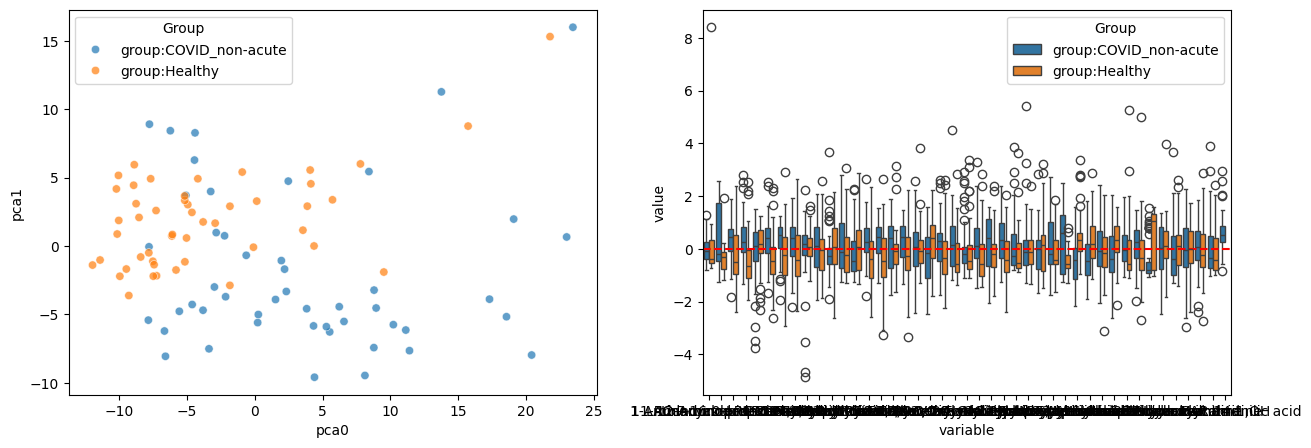

In [384]:
ST002016.plot_qc()

In [392]:
ST002301 = WorkbenchDataset(
    study_id='ST002301',
    # filepath='AN003757.csv',
    md_filter={'Control': 'Severity of Disease:Asymptomatic', 'Case': 'Severity of Disease:Severe'})

Missingness: 3.78%
Number of differentially abundant metabolites: 31


C:\Users\cw2019\AppData\Local\Temp\ipykernel_66232\2157376236.py:88: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


In [386]:
ST002301.processed_data.shape

(150, 93)

In [387]:
ST002301.processed_data

,1-Methyladenosine,2-Pyrrolidinone,3-Indolepropionic acid,3-Methylindole,3-Methylxanthine,4-Aminophenol,5-Hydroxyindoleacetic acid,5-Hydroxy-tryptophan,9-Methyluric acid,Acetaminophen,...,Sphingosine,Succinic acid,Succinylacetone,Thyroxine,Trimethylamine,Urea,N-Carbamoylaspartic acid,Uric acid,Uridine,Group
Samples,,,,,,,,,,,,,,,,,,,,,
Plasma35-01_41_1_2344,-0.410495,2.967939,1.149424,-0.054903,-0.102755,1.109235,0.446829,-1.943437,-0.060562,1.182997,...,1.930979,-1.522422,0.112247,-0.408366,-0.068881,-2.511496,0.577640,0.064137,-2.518393,Severity of Disease:Asymptomatic
Plasma35-02_41_1_2345,-0.602777,2.428257,1.094336,-0.021960,0.004071,1.138148,0.238900,-1.730955,0.014656,1.192927,...,2.218925,-0.898658,0.168954,0.093750,-0.097766,-3.650480,-0.414285,0.689469,-2.176128,Severity of Disease:Asymptomatic
Plasma36-01_42_1_2346,-1.620672,3.105157,1.479806,0.621857,0.991852,-1.009483,-0.757488,0.181689,0.734329,-0.923478,...,0.462863,0.936072,0.414117,0.395983,0.776820,-0.492577,-1.050423,0.269238,-1.840380,Severity of Disease:Asymptomatic
Plasma36-02_42_1_2347,0.273588,3.272333,1.316169,0.682260,0.958401,-0.900611,-0.735027,0.468630,0.632600,-0.898551,...,0.648044,1.121428,-0.156841,0.141966,0.798582,-1.986787,-0.157311,1.231639,-1.499797,Severity of Disease:Asymptomatic
Plasma37-01_43_1_2348,-0.847621,2.925202,1.421728,0.353679,-1.039472,-0.682503,0.199688,-0.951375,-1.221760,-0.474039,...,1.897320,-0.425232,0.348289,1.119572,0.946812,-0.513141,0.677903,-0.262631,-1.028572,Severity of Disease:Asymptomatic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Plasma83-02_89_1_2455,-0.198777,-1.495349,-0.771112,-0.296626,-0.790472,1.401227,-1.362326,-1.488316,-1.281079,1.341681,...,-1.358153,-0.229043,-0.856302,-2.015858,0.328087,-0.407237,0.164324,-0.496282,0.903209,Severity of Disease:Severe
Plasma84-01_90_1_2456,0.649940,-1.204574,-0.044785,0.522582,-1.022806,0.467562,-0.306385,0.754779,-0.304556,0.500308,...,1.655211,0.299898,-1.573495,0.955822,-3.032179,-1.042404,-1.001813,1.587613,-0.273047,Severity of Disease:Severe
Plasma84-02_90_1_2457,0.331474,-1.608606,0.406036,0.378144,-1.263359,0.570576,-0.191732,0.594735,-0.367831,0.530114,...,1.216726,0.389654,-1.084485,1.025237,-2.905269,-0.900655,-0.725027,1.852979,-1.150450,Severity of Disease:Severe


In [388]:
ST002301.processed_data['Group'].value_counts()

Group
Severity of Disease:Severe          90
Severity of Disease:Asymptomatic    60
Name: count, dtype: int64

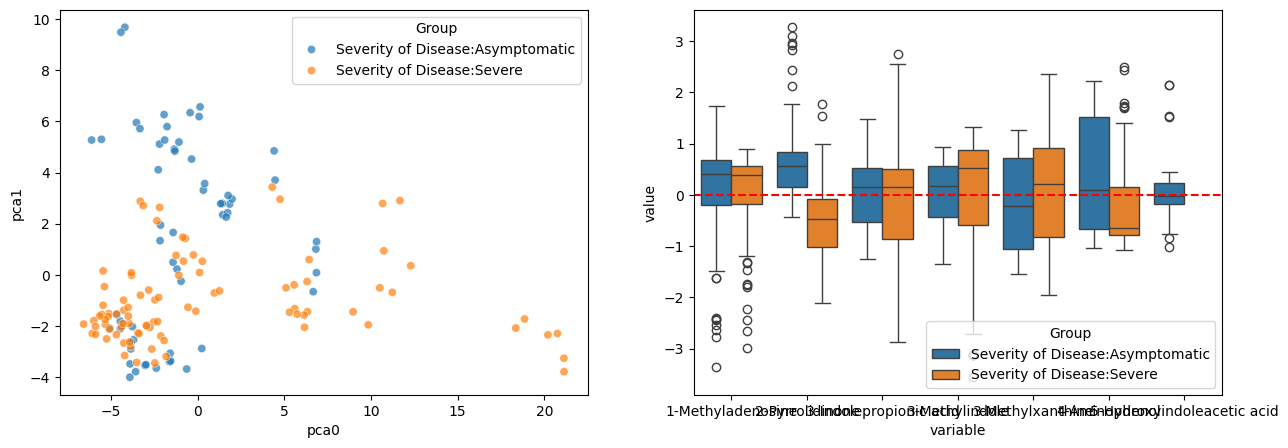

In [389]:
ST002301.plot_qc()

In [393]:
ST001736 = WorkbenchDataset(
    study_id='ST001736',
    # filepath='AN002826_updated.csv',
    md_filter={'Control': 'COVID_Status:Negative', 'Case': 'COVID_Status:Positive'})

C:\Users\cw2019\AppData\Local\Temp\ipykernel_66232\2157376236.py:88: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


Missingness: 0.82%


Missingness: 2.72%
Number of differentially abundant metabolites: 3


C:\Users\cw2019\AppData\Local\Temp\ipykernel_66232\2157376236.py:88: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


In [394]:
ST001736.processed_data

,3-Methyleneoxindole,4-Acetamidobutanoic acid,5-Hydroxyindoleacetic acid,5-Hydroxyisouric acid,gamma-Glutamylglutamine,Acetylcholine,Alanine,Allantoic acid,2-Aminobenzoic acid,Arginine,...,Pantothenic acid,Phosphoric acid,Phosphoenolpyruvic acid,Pyruvic acid,Succinic acid,Taurine,Thymine,trans-4-Hydroxyproline,UDP,Group
Samples,,,,,,,,,,,,,,,,,,,,,
CUcovID_0037,-1.195304,-0.177598,-0.053416,-1.696239,-0.731249,-0.288194,-1.137307,-0.882160,-0.851381,-1.633192,...,-0.914061,-1.036013,0.473731,0.016713,-1.562528,-0.770139,-0.781035,-1.171038,-2.845470,COVID_Status:Negative
CUcovID_0094,-1.327105,-0.398977,1.491737,-0.716047,-0.691719,-0.676216,-0.655300,-0.698948,-1.346262,-1.230952,...,-0.024075,0.782532,-0.005685,-0.837434,-0.478999,0.533387,0.093889,-1.277670,0.902387,COVID_Status:Negative
CUcovID_0028,0.246600,-0.534104,0.736302,-0.890392,-0.042740,-0.004660,-0.764800,-0.093959,-0.475525,-0.402315,...,-1.170433,-0.847806,0.307835,-0.765879,0.232548,0.465658,0.305814,-1.364326,1.046791,COVID_Status:Negative
CUcovID_0079,1.491527,0.736494,0.440572,-0.408585,0.416002,-1.553097,0.841889,0.694390,0.584698,-0.693634,...,-0.442622,0.958692,-0.893455,-0.631933,-0.677015,-0.506346,0.507554,1.124038,0.743820,COVID_Status:Negative
CUcovID_0017,0.115540,-0.324194,0.505983,0.773731,1.145826,0.777705,0.753774,0.544722,-0.391833,-0.147286,...,0.223919,0.146637,0.617405,0.859793,1.079973,1.191524,0.661345,-1.318413,-0.178552,COVID_Status:Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CUcovID_0056,0.064781,-0.873240,-0.238705,-0.511856,0.634791,-0.546363,0.672286,-0.892906,-0.270527,-0.064371,...,0.741864,-0.563130,-0.009594,-1.025227,-0.481557,0.526786,-5.224171,-0.937401,0.590905,COVID_Status:Positive
CUcovID_0057,1.225233,0.003025,-0.030598,1.498187,0.987376,0.906437,1.084836,1.095020,-0.222503,1.004077,...,-0.116955,0.438327,0.343674,0.332677,0.117583,0.189745,1.061575,0.381878,0.765335,COVID_Status:Positive
CUcovID_0062,1.727100,-0.322875,-1.033367,-0.283434,-4.437509,0.495705,1.207251,1.854973,0.473122,-1.613708,...,-0.994901,1.477855,-1.280268,1.428359,1.407557,-0.544873,0.072207,0.353599,0.519476,COVID_Status:Positive


In [395]:
ST001736.processed_data['Group'].value_counts()

Group
COVID_Status:Positive    71
COVID_Status:Negative    31
Name: count, dtype: int64

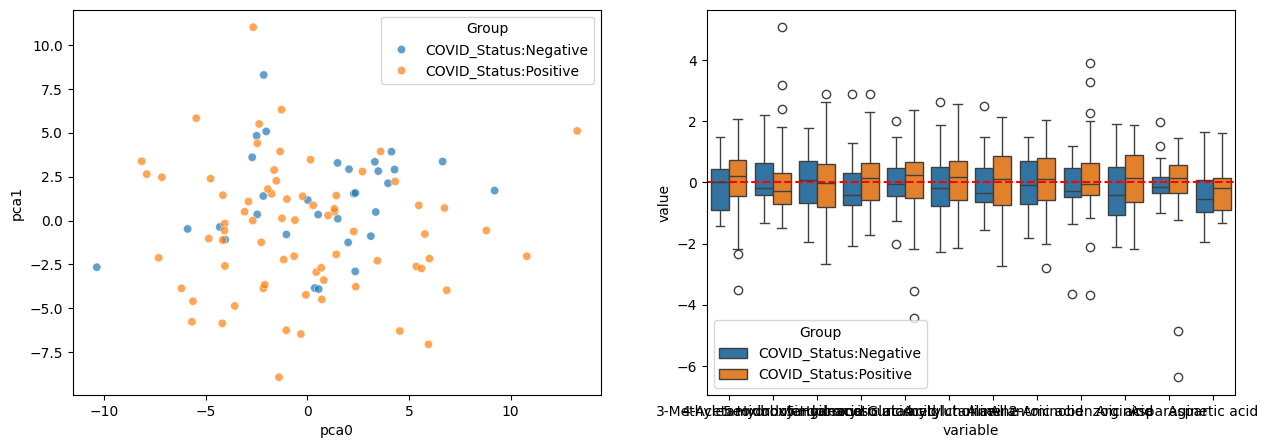

In [396]:
ST001736.plot_qc()

In [397]:
ST001933 = WorkbenchDataset(
    study_id='ST001933',
    md_filter={'Control': 'Group:H', 'Case': 'Group:CA'})

Missingness: 2.90%
Number of differentially abundant metabolites: 1


C:\Users\cw2019\AppData\Local\Temp\ipykernel_66232\2157376236.py:88: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


In [326]:
ST001933.processed_data['Group'].value_counts()

Group
Group:H     35
Group:CA    17
Name: count, dtype: int64

In [327]:
ST001933.processed_data.shape

(52, 180)

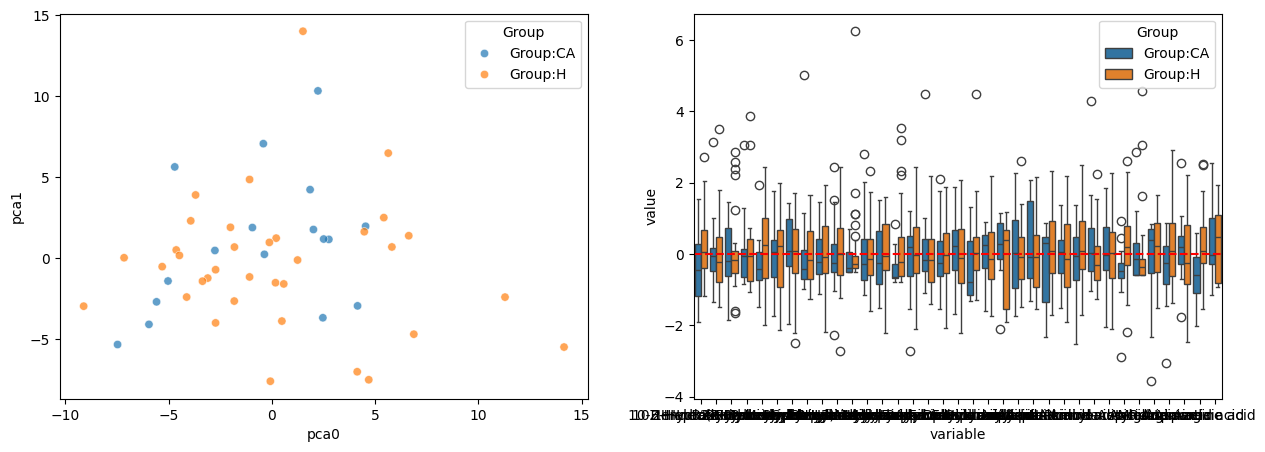

In [398]:
ST001933.plot_qc()

## IBD

In [406]:
ST000899 = WorkbenchDataset(
    study_id='ST000899',
    md_filter={'Control': 'Type:Control', 'Case': 'Type:Ulcerative Colitis'})

C:\Users\cw2019\AppData\Local\Temp\ipykernel_66232\2157376236.py:88: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


Missingness: 7.14%


C:\Users\cw2019\AppData\Local\Temp\ipykernel_66232\2157376236.py:88: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


Missingness: 1.46%


C:\Users\cw2019\AppData\Local\Temp\ipykernel_66232\2157376236.py:88: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


Missingness: 5.01%
Missingness: 2.80%
Number of differentially abundant metabolites: 0


C:\Users\cw2019\AppData\Local\Temp\ipykernel_66232\2157376236.py:88: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


In [407]:
ST000899.processed_data['Group'].value_counts()

Group
Type:Control               20
Type:Ulcerative Colitis    20
Name: count, dtype: int64

In [404]:
ST000899.processed_data.shape   

(40, 523)

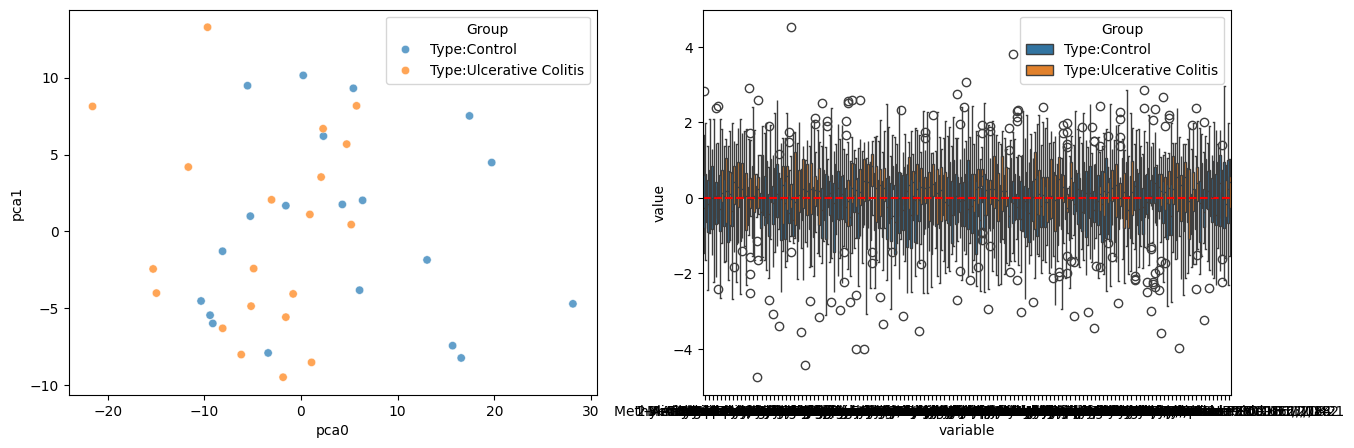

In [408]:
ST000899.plot_qc()

## Cancer

In [418]:
ST000284 = WorkbenchDataset(
    study_id='ST000284',
    md_filter={'Control': 'Patient group:Healthy', 'Case': 'Patient group:CRC'})

Missingness: 0.00%
Number of differentially abundant metabolites: 7


C:\Users\cw2019\AppData\Local\Temp\ipykernel_66232\2157376236.py:88: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


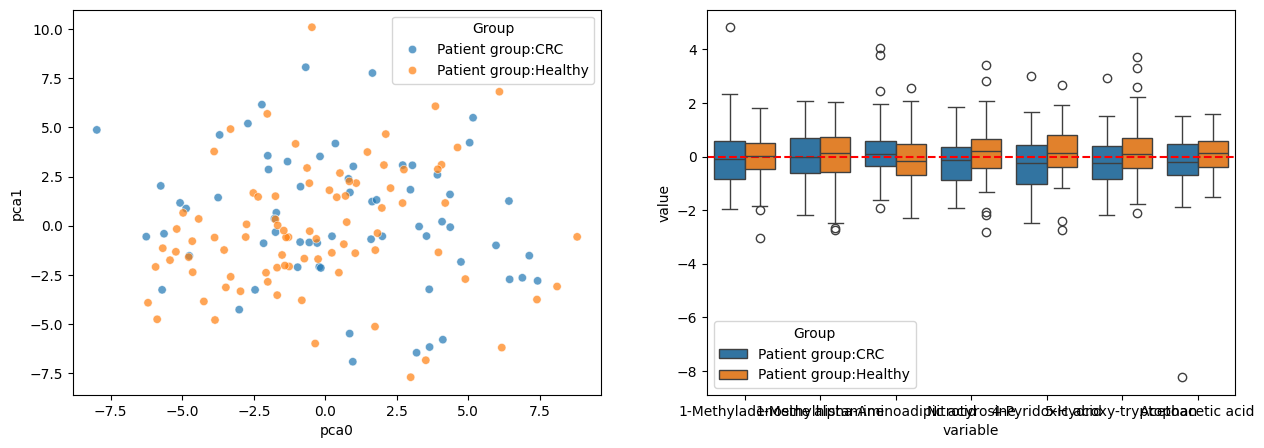

In [419]:
ST000284.plot_qc()

## TB

In [435]:
ST002428 = WorkbenchDataset(
    study_id='ST002428',
    # filepath='AN002826_updated.csv',
    md_filter={'Control': 'Label:Controls', 'Case': 'Label:TB'})

C:\Users\cw2019\AppData\Local\Temp\ipykernel_66232\2157376236.py:88: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


Missingness: 5.27%
Missingness: 4.91%
Number of differentially abundant metabolites: 0


C:\Users\cw2019\AppData\Local\Temp\ipykernel_66232\2157376236.py:88: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T
c:\Users\cw2019\.conda\envs\py12\Lib\site-packages\scipy\stats\_axis_nan_policy.py:563: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


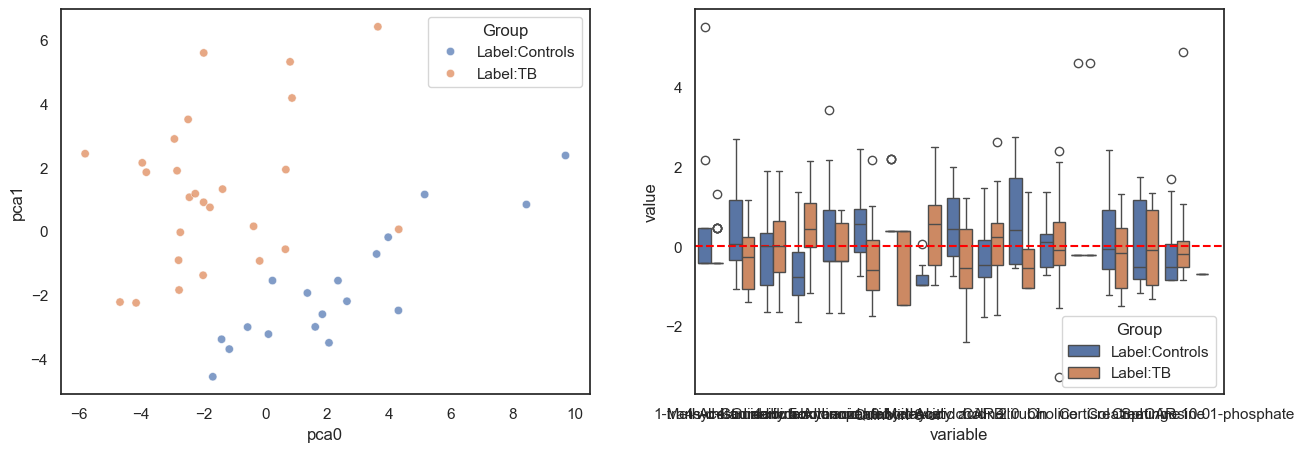

In [436]:
ST002428.plot_qc()

In [438]:
ST002428.pval_df.sort_values(by='P-value')

,P-value,Stat,Direction,FDR_P-value
Tryptophan,1.100015e-07,-6.387464,Down,NaN
9-Methyluric acid,1.866685e-06,5.531845,Up,NaN
Methionine,1.189332e-05,-4.965842,Down,NaN
Hexanoylglycine,1.255960e-05,4.949025,Up,NaN
4-Guanidinobutanoic acid,2.743966e-05,4.706573,Up,NaN
...,...,...,...,...
Pipecolic acid,9.197836e-01,-0.101314,Down,NaN
Glutamine,9.280233e-01,-0.090876,Down,NaN
Isovalerylglycine,9.803711e-01,0.024751,Up,NaN
2-Methylhippuric acid,NaN,NaN,Down,NaN


In [445]:
#split md
st000974 = pd.read_csv('Studies\ST000974\AN001595.csv')


<>:2: SyntaxWarning: invalid escape sequence '\S'
<>:2: SyntaxWarning: invalid escape sequence '\S'
C:\Users\cw2019\AppData\Local\Temp\ipykernel_66232\1668443190.py:2: SyntaxWarning: invalid escape sequence '\S'
  st000974 = pd.read_csv('Studies\ST000974\AN001595.csv')


In [453]:
st000974['Class'] = st000974['Class'].str.split(' | ').str[0]

In [454]:
st000974.to_csv('Studies\ST000974\AN001595.csv', index=False)

<>:1: SyntaxWarning: invalid escape sequence '\S'
<>:1: SyntaxWarning: invalid escape sequence '\S'
C:\Users\cw2019\AppData\Local\Temp\ipykernel_66232\3511435816.py:1: SyntaxWarning: invalid escape sequence '\S'
  st000974.to_csv('Studies\ST000974\AN001595.csv', index=False)


In [456]:
ST000974 = WorkbenchDataset(
    study_id='ST000974',
    # filepath='AN002826_updated.csv',
    md_filter={'Control': 'GROUP:control', 'Case': 'GROUP:case'})

C:\Users\cw2019\AppData\Local\Temp\ipykernel_66232\2157376236.py:88: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


Missingness: 0.26%
Number of differentially abundant metabolites: 1


c:\Users\cw2019\.conda\envs\py12\Lib\site-packages\scipy\stats\_axis_nan_policy.py:563: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


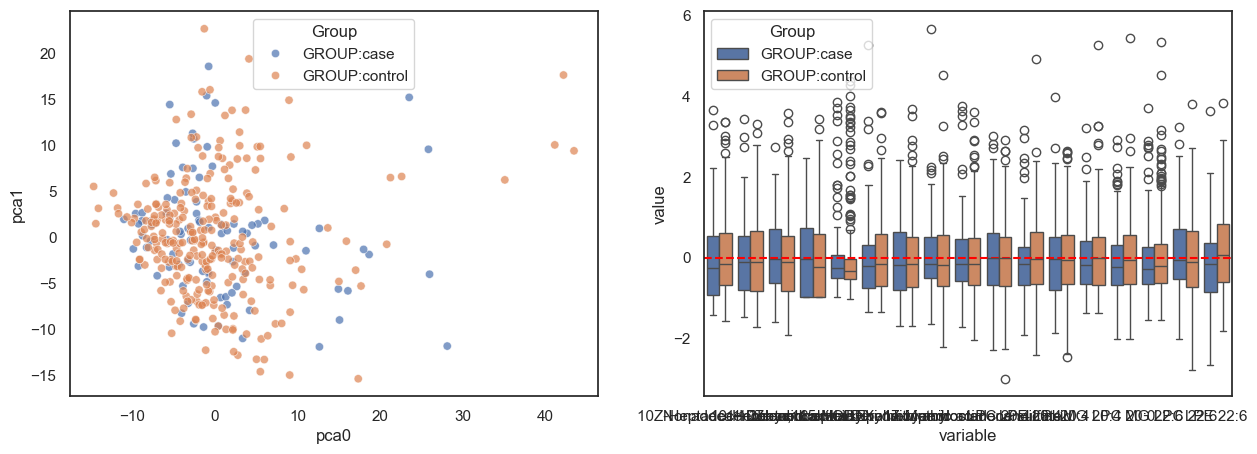

In [457]:
ST000974.plot_qc()


## Hepatitis

In [462]:

ST002100 = WorkbenchDataset(
    study_id='ST002100',
    # filepath='AN002826_updated.csv',
    md_filter={'Control': 'Treatment:Healthy', 'Case': 'Treatment:Acute hepatitis'})

C:\Users\cw2019\AppData\Local\Temp\ipykernel_66232\2157376236.py:88: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


Missingness: 0.00%


Missingness: 0.00%
Number of differentially abundant metabolites: 46


C:\Users\cw2019\AppData\Local\Temp\ipykernel_66232\2157376236.py:88: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


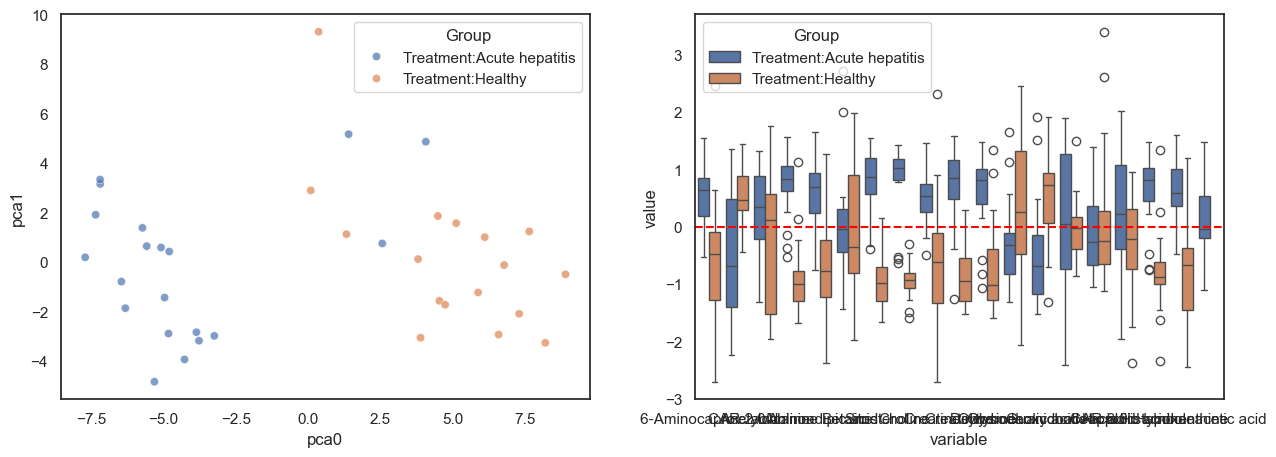

In [463]:
ST002100.plot_qc()

# Network

In [409]:
def get_bipartite(studies):
    B = nx.Graph()
    # Add nodes with the node attribute "bipartite"-

    B.add_nodes_from([i.node_name for i in studies], bipartite=0)
    B.add_nodes_from(sum([i.DA_metabolites for i in studies], []), bipartite=1)
    # Add edges only between nodes of opposite node sets
    B.add_edges_from(sum([i.connection for i in studies], []))
    bottom_nodes, top_nodes = bipartite.sets(B)
    nx.is_connected(B)
    return B, bottom_nodes, top_nodes


In [410]:
for i in [ST002016, ST002301, ST001736, ST001933]:
    print(i.node_name, len(i.DA_metabolites))

ST002016 134
ST002301 31
ST001736 3
ST001933 1


In [464]:


covid_bpt, covid_bottom_nodes, covid_top_nodes = get_bipartite([ST002016, ST002301, ST000284, ST002100])


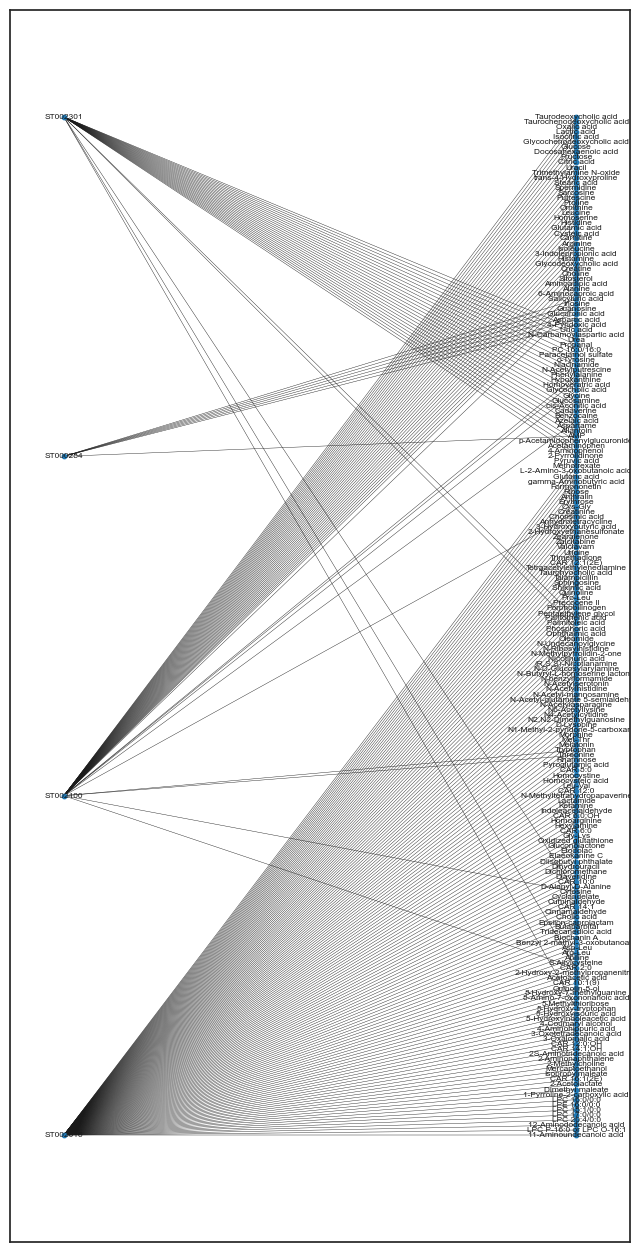

In [465]:
plt.figure(3,figsize=(8,16)) 
nx.draw_networkx(
    covid_bpt,
    pos = nx.drawing.layout.bipartite_layout(covid_bpt, covid_bottom_nodes),
    font_size=6,
    width = 0.3,
    with_labels=True,
    node_size=10,
    ) # Or whatever other display options you like

plt.show()


ST002016
ST002301
ST000284
ST002100


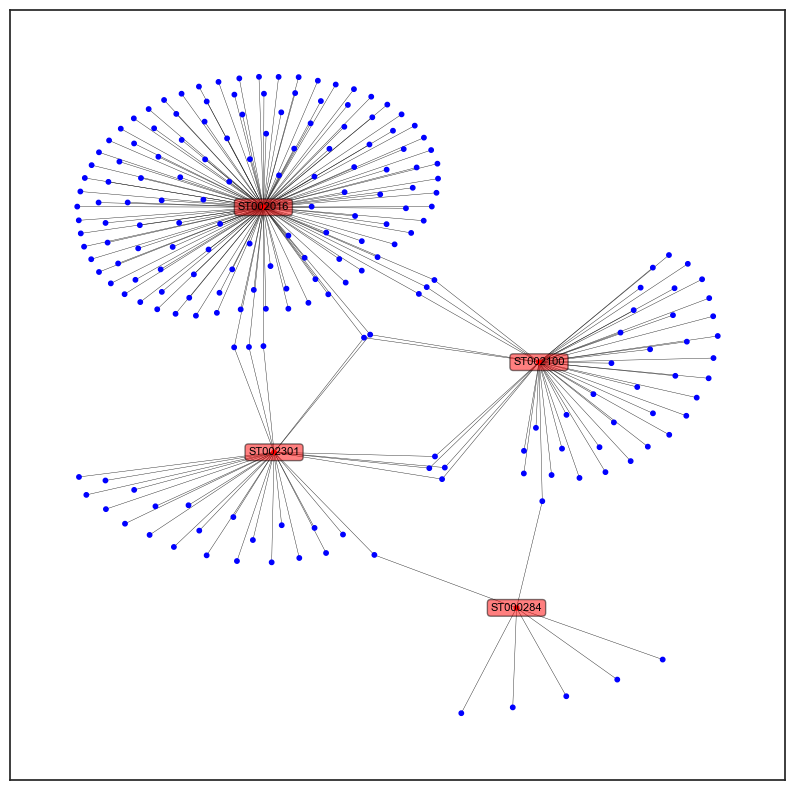

In [466]:

# force directed layout
pos = nx.drawing.layout.kamada_kawai_layout(covid_bpt)
color_map = []
labels = {}
for node in covid_bpt:
    if node in covid_bottom_nodes:
        print(node)
        color_map.append('red')
        labels[node] = node
    else: 
        color_map.append('blue')    
        # labels[node] = ''  


plt.figure(3,figsize=(10 ,10)) 
nx.draw_networkx(
    covid_bpt,
    pos = pos,
    font_size=6,
    width = 0.3,
    with_labels=False,
    node_size=10,
    node_color=color_map
    ) # Or whatever other display options you like
nx.draw_networkx_labels(covid_bpt, pos, labels,
                        bbox = dict(facecolor = "red", alpha=0.5, edgecolor='black', boxstyle='round,pad=0.3'),
                        font_size=8,
                        font_color='black')

plt.show()

In [467]:
biadj_mat = nx.bipartite.biadjacency_matrix(covid_bpt, row_order=covid_bottom_nodes, column_order=covid_top_nodes).toarray()

# create adjacency matrix based on the number of shared metabolites
# this can be done by multiplying the biadjacency matrix by its transpose
adj_mat = pd.DataFrame(biadj_mat @ biadj_mat.T, index=list(covid_bottom_nodes), columns=list(covid_bottom_nodes))


c:\Users\cw2019\.conda\envs\py12\Lib\site-packages\seaborn\matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


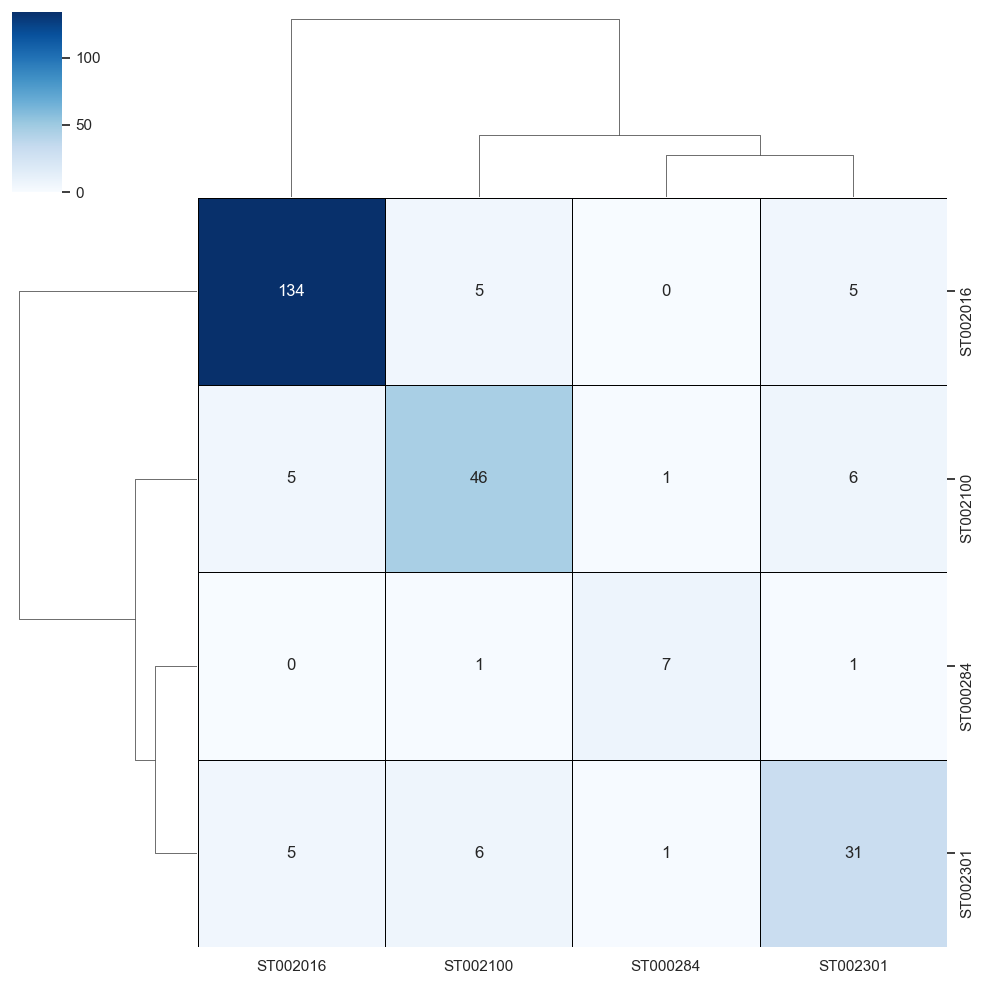

In [468]:

# fig, ax = plt.subplots(figsize=(7, 5))
sns.set(style='white')
sns.clustermap(
    adj_mat, 
    cmap='Blues', 
    square=True, 
    annot=True, 
    # cbar=False, 
    fmt='d', 
    linewidths=0.5, 
    linecolor='black' )
# ax.set_yticklabels(bottom_nodes, rotation=0)
# ax.set_xticklabels(bottom_nodes, rotation=90)
# ax.set_title('Similarity matrix of differential metabolites')
# plt.tight_layout()
plt.show()


In [469]:

# create adjacency matrix based on the number of shared metabolites
# this can be done by multiplying the biadjacency matrix by its transpose
adj_mat_dmn = pd.DataFrame(biadj_mat.T @ biadj_mat, index=list(covid_top_nodes), columns=list(covid_top_nodes))


# make pandas edgelist
edgelist_dmn = adj_mat_dmn.stack().reset_index()
edgelist_dmn.columns = ['source', 'target', 'weight']
edgelist_dmn = edgelist_dmn[edgelist_dmn['weight'] > 1]


In [470]:
edgelist_dmn.sort_values('weight', ascending=False)

,source,target,weight
406,Cytosine,Cytosine,3
19082,CAR 2:0,CAR 2:0,3
498,Cytosine,CAR 2:0,3
18990,CAR 2:0,Cytosine,3
20092,Glycocholic acid,CAR 2:0,2
...,...,...,...
8811,5-Hydroxy-tryptophan,Phosphoric acid,2
8780,5-Hydroxy-tryptophan,CAR 2:0,2
8729,5-Hydroxy-tryptophan,5-Hydroxy-tryptophan,2
8690,5-Hydroxy-tryptophan,Pantothenic acid,2


In [471]:
edgelist_dmn.sort_values('weight', ascending=False)
dmn_graph = nx.from_pandas_edgelist(edgelist_dmn, edge_attr='weight')
dmn_graph.remove_edges_from(nx.selfloop_edges(dmn_graph))
nx.set_node_attributes(dmn_graph, dict(dmn_graph.degree()), 'degree')

print(dmn_graph.number_of_nodes())
print(dmn_graph.number_of_edges())


14
33
